<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/%22fit_ensemble%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

!pip install pmdarima -q
#from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima


# **Переменные**

In [ ]:
cpi = "month"
reg_names = ['SFO']
data_do = "2020-12-01"
train_do = "2019-01-01"

mes = (pd.to_datetime(data_do).to_period('M') - pd.to_datetime(train_do).to_period('M')).n+1
result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'mes', 'method', 'rmse'])

In [ ]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)

In [ ]:
# for ML
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')
data['month'] = pd.DatetimeIndex(data.index).month

train = data[data.index < train_do]
test = data[data.index >= train_do]

# **ARIMA**

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=261.834, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=218.492, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=173.737, Time=0.69 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=263.359, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=173.884, Time=0.76 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=172.460, Time=1.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=168.217, Time=3.15 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=167.371, Time=2.58 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=170.770, Time=1.80 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=172.216, Time=2.04 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=148.019, Time=6.62 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=5.48 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=4.55 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=in

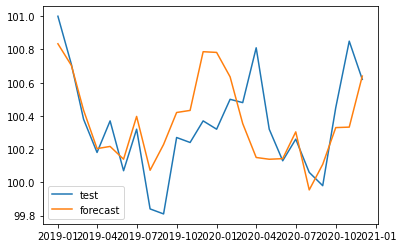

In [ ]:
# find best params for ARIMA
stepwise_model = auto_arima(train[reg_names], test='adf', start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, 
                                D=1, d=1, max_d=4, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion = 'aic')
#                               out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names], label="test")
plt.plot(future_forecast[reg_names], label="forecast")
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))


In [ ]:
result = pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])
result_arima = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMA', 'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arima, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671


# **ARIMAX**

In [ ]:
exogenous_features = ['month', 'curs']

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=146.650, Time=2.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=247.238, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=190.983, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=151.819, Time=0.86 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=145.888, Time=1.71 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=184.483, Time=1.26 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=143.251, Time=4.04 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=159.900, Time=2.81 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=140.052, Time=7.33 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=141.668, Time=6.46 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=142.940, Time=4.03 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=147.883, Time=4.71 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=141.949, Time=7.81 sec
 ARIMA(1,1,2)(2,1,2)[12]             

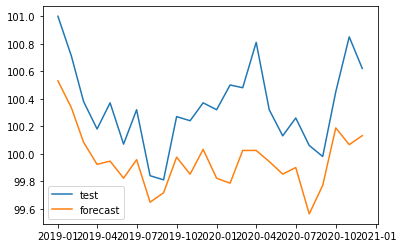

In [ ]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], test='adf', start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion = 'aic')
#                            out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names], label="test")
plt.plot(future_forecast[reg_names], label="forecast")
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [ ]:
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])

In [ ]:
result_arimax = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMAX', 
                'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arimax, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908


# **Feature Engineering**

In [ ]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in {1, 6, 12}:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

,curs,t,t-1,t-12,t-6,month
date,,,,,,
2003-01-01,31.816165,102.50,101.30,102.70,101.10,1
2003-02-01,31.698979,101.93,102.50,101.10,100.10,2
2003-03-01,31.453290,101.19,101.93,101.10,100.80,3
2003-04-01,31.211786,101.07,101.19,101.00,101.30,4
2003-05-01,30.907055,100.62,101.07,101.30,101.30,5
...,...,...,...,...,...,...
2020-08-01,73.798110,100.06,100.26,99.84,100.50,8
2020-09-01,75.727986,99.98,100.06,99.81,100.48,9
2020-10-01,77.663548,100.45,99.98,100.27,100.81,10


In [ ]:
df=data_lags
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("date", drop=True, inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [ ]:
data = df
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()

X = data.drop(['t'], axis=1).values
y = data[['t']].values.ravel()

# **SCALER**

In [ ]:
# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_m = scaler.transform(X_train)
X_test_m = scaler.transform(X_test)

In [ ]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])
result

,ARIMA,ARIMAX,y_test
date,,,
2019-01-01,100.834281,100.530149,101.00
2019-02-01,100.703752,100.334420,100.71
2019-03-01,100.434335,100.083118,100.38
2019-04-01,100.203067,99.922618,100.18
2019-05-01,100.216300,99.946081,100.37
2019-06-01,100.139256,99.822307,100.07
2019-07-01,100.396997,99.956671,100.32
2019-08-01,100.072782,99.647516,99.84
2019-09-01,100.228083,99.715900,99.81


# **KNeighborsRegressor**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=5)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.70
Test set score: -0.06
rmse: 0.3036
normed rmse: 0.3025%


In [ ]:
result['KNR']=pd.DataFrame(np.array(forecast), index = test.index, columns=['KNR'])
result_KNR = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'KNR', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_KNR, ignore_index = True)
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601


# **OLS**

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_m, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train_m, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test_m, y_test)))

forecast = lr.predict(X_test_m)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.60
Test set score: -0.08
rmse: 0.3067
normed rmse: 0.3057%


In [ ]:
result['OLS']=pd.DataFrame(np.array(forecast), index = test.index, columns=['OLS'])
result_OLS = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'OLS', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_OLS, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730


# **Ridge (l2-regularisation)**

In [ ]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(MinMaxScaler(), Ridge())
GSRidge = GridSearchCV(pipe, param_grid, cv=5)
GSRidge.fit(X_train, y_train)
print("Training set score: {:.2f}".format(GSRidge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(GSRidge.score(X_test, y_test)))

forecast = GSRidge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.39
Test set score: 0.20
rmse: 0.26355
normed rmse: 0.26%


In [ ]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result_Ridge = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Ridge', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Ridge, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730
4,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.263553


# **Lasso (l1-regularisation)**

In [ ]:
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train_m, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train_m, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test_m, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test_m)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.48
Test set score: 0.35
Number of features used: 4
rmse: 0.23826
normed rmse: 0.24%


In [ ]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result_Lasso = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Lasso', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Lasso, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730
4,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.263553
5,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.238259


# **ElasticNet (l1+l2-regularisation)**

In [ ]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.46
Test set score: 0.24
Number of features used: 7
rmse: 0.25812
normed rmse: 0.26%


In [ ]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result_ElasticNet = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ElasticNet', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730
4,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.263553
5,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.238259
6,month,[SFO],2020-12-01,2019-01-01,24,ElasticNet,0.258118


# **GridSearch DecisionTree**

Parameter grid:
{'max_depth': [1, 2, 3, 5, 10], 'min_samples_leaf': [1, 2, 3, 50, 100], 'max_leaf_nodes': [10, 20, 30, 500, 1000]}
Test set score: -0.01
Best parameters: {'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 3}
Best estimator:
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
rmse: 0.2967
normed rmse: 0.2957%


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730
4,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.263553
5,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.238259
6,month,[SFO],2020-12-01,2019-01-01,24,ElasticNet,0.258118
7,month,[SFO],2020-12-01,2019-01-01,24,GSDT,0.296684


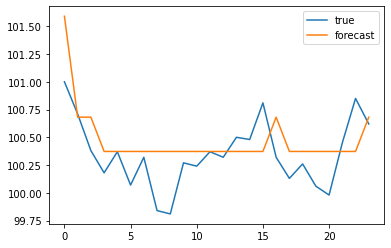

In [ ]:
param_grid = {'max_depth': [1, 2, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 50, 100],
              'max_leaf_nodes': [10, 20, 30, 500, 1000]}
print("Parameter grid:\n{}".format(param_grid))

GSDT = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=30)
GSDT.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSDT.score(X_test, y_test)))
print("Best parameters: {}".format(GSDT.best_params_))
print("Best estimator:\n{}".format(GSDT.best_estimator_))

# make predictions
GSDT_forecast = GSDT.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSDT_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSDT_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSDT_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

result['GSDT']=pd.DataFrame(np.array(GSDT_forecast), index = test.index, columns=['GSDT'])
result_GSDT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSDT', 
                'rmse': mean_squared_error(y_test, GSDT_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSDT, ignore_index = True) 
result_rmse

# **Plot_features**

In [ ]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')


In [ ]:
def plot_features_GS(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.best_estimator_.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')

# **GSRF**

Parameter grid:
{'n_estimators': [1, 10, 50, 100, 200, 300]}
Test set score: 0.47
Best parameters: {'n_estimators': 10}
Best estimator:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rmse: 0.2151
normed rmse: 0.2144%
Accuracy on training set: 0.932
Accuracy on test set: 0.470


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730
4,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.263553
5,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.238259
6,month,[SFO],2020-12-01,2019-01-01,24,ElasticNet,0.258118
7,month,[SFO],2020-12-01,2019-01-01,24,GSDT,0.296684
8,month,[SFO],2020-12-01,2019-01-01,24,GSRF,0.215134


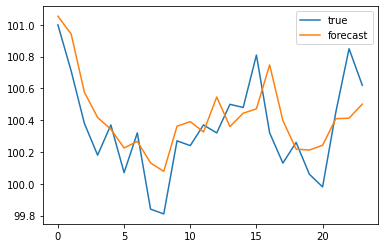

In [ ]:
param_grid = {'n_estimators': [1, 10, 50, 100, 200, 300]}
print("Parameter grid:\n{}".format(param_grid))

GSRF = GridSearchCV(RandomForestRegressor(), param_grid, cv=30)
GSRF.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSRF.score(X_test, y_test)))
print("Best parameters: {}".format(GSRF.best_params_))
print("Best estimator:\n{}".format(GSRF.best_estimator_))

# make predictions
GSRF_forecast = GSRF.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSRF_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSRF_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSRF_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSRF.score(X_test, y_test)))

result['GSRF']=pd.DataFrame(np.array(GSRF_forecast), index = test.index, columns=['GSRF'])

result_GSRF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSRF', 
                'rmse': mean_squared_error(y_test, GSRF_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSRF, ignore_index = True) 
result_rmse

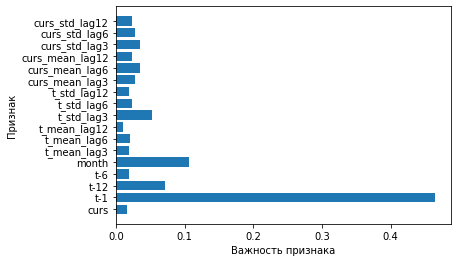

In [ ]:
plot_features_GS(GSRF)

# **Grid Search XGB**

Parameter grid:
{'max_depth': [1, 2, 3, 5, 10], 'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
Test set score: 0.24
Best parameters: {'max_depth': 1, 'n_estimators': 100}
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
rmse: 0.2580
normed rmse: 0.2571%
Accuracy on training set: 0.671
Accuracy on test set: 0.237


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730
4,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.263553
5,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.238259
6,month,[SFO],2020-12-01,2019-01-01,24,ElasticNet,0.258118
7,month,[SFO],2020-12-01,2019-01-01,24,GSDT,0.296684
8,month,[SFO],2020-12-01,2019-01-01,24,GSRF,0.215134
9,month,[SFO],2020-12-01,2019-01-01,24,GSXGB,0.258008


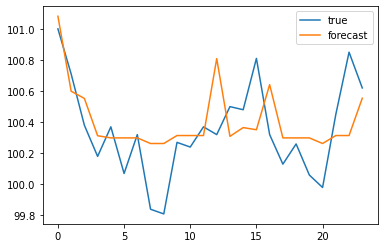

In [ ]:
param_grid = {'max_depth': [1, 2, 3, 5, 10],
              'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
print("Parameter grid:\n{}".format(param_grid))

GSXGB = GridSearchCV(XGBRegressor(objective ='reg:squarederror'), param_grid, cv=30)
GSXGB.fit(X_train, y_train, verbose=False)

print("Test set score: {:.2f}".format(GSXGB.score(X_test, y_test)))
print("Best parameters: {}".format(GSXGB.best_params_))
print("Best estimator:\n{}".format(GSXGB.best_estimator_))

# make predictions
GSXGB_forecast = GSXGB.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSXGB_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSXGB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSXGB.score(X_test, y_test)))

result['GSXGB']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GSXGB'])

result_GSXGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSXGB', 
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSXGB, ignore_index = True) 
result_rmse

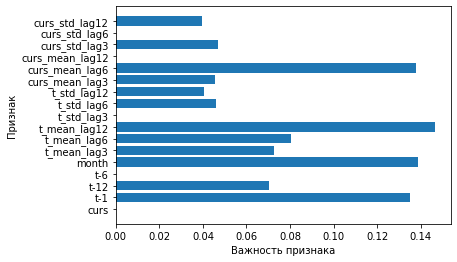

In [ ]:
plot_features_GS(GSXGB)

# **Results**

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,KNR,0.303601
3,month,[SFO],2020-12-01,2019-01-01,24,OLS,0.306730
4,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.263553
5,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.238259
6,month,[SFO],2020-12-01,2019-01-01,24,ElasticNet,0.258118
7,month,[SFO],2020-12-01,2019-01-01,24,GSDT,0.296684
8,month,[SFO],2020-12-01,2019-01-01,24,GSRF,0.215134
9,month,[SFO],2020-12-01,2019-01-01,24,GSXGB,0.258008


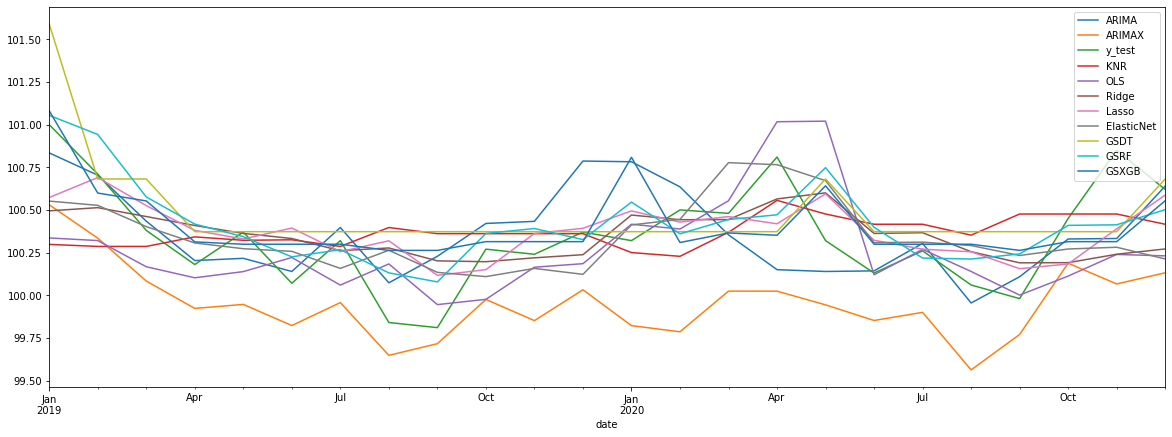

In [ ]:
result.plot(figsize=(20, 7))
result_rmse

In [ ]:
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,GSDT,GSRF,GSXGB
date,,,,,,,,,,,
2019-01-01,100.834281,100.530149,101.00,100.29800,100.335690,100.494456,100.572640,100.551769,101.590000,101.05442,101.081139
2019-02-01,100.703752,100.334420,100.71,100.28600,100.320361,100.513306,100.689820,100.526813,100.681273,100.94242,100.598892
2019-03-01,100.434335,100.083118,100.38,100.28600,100.166938,100.461248,100.525318,100.402107,100.681273,100.57600,100.552719
2019-04-01,100.203067,99.922618,100.18,100.34200,100.102147,100.408762,100.379991,100.306405,100.372508,100.41700,100.312675
2019-05-01,100.216300,99.946081,100.37,100.32200,100.138401,100.362513,100.329518,100.272649,100.372508,100.34300,100.298851
2019-06-01,100.139256,99.822307,100.07,100.32484,100.221109,100.332389,100.393830,100.257133,100.372508,100.22500,100.298851
2019-07-01,100.396997,99.956671,100.32,100.28600,100.059285,100.261057,100.255071,100.157169,100.372508,100.26700,100.298851
2019-08-01,100.072782,99.647516,99.84,100.39684,100.183289,100.277060,100.319149,100.263486,100.372508,100.13100,100.262764
2019-09-01,100.228083,99.715900,99.81,100.36084,99.944991,100.201515,100.116389,100.133925,100.372508,100.07800,100.262764


In [ ]:
train.head()

,curs,t,t-1,t-12,t-6,month,t_mean_lag3,t_mean_lag6,t_mean_lag12,t_std_lag3,t_std_lag6,t_std_lag12,curs_mean_lag3,curs_mean_lag6,curs_mean_lag12,curs_std_lag3,curs_std_lag6,curs_std_lag12
date,,,,,,,,,,,,,,,,,,
2003-01-01,31.816165,102.50,101.30,102.7,101.1,1,100.650444,100.662292,100.677620,0.256900,0.336531,0.405590,41.006077,40.701084,40.130470,1.063051,1.598212,2.241186
2003-02-01,31.698979,101.93,102.50,101.1,100.1,2,102.500000,102.500000,102.500000,0.256900,0.336531,0.405590,31.816166,31.816166,31.816166,1.063051,1.598212,2.241186
2003-03-01,31.453290,101.19,101.93,101.1,100.8,3,102.214996,102.214996,102.214996,0.403051,0.403051,0.403051,31.757572,31.757572,31.757572,0.082863,0.082863,0.082863
2003-04-01,31.211786,101.07,101.19,101.0,101.3,4,101.873337,101.873337,101.873337,0.656836,0.656836,0.656836,31.656145,31.656145,31.656145,0.185191,0.185191,0.185191
2003-05-01,30.907055,100.62,101.07,101.3,101.3,5,101.396667,101.672501,101.672501,0.465761,0.670044,0.670044,31.454685,31.545055,31.545055,0.243599,0.268751,0.268751


# **Blend**

In [ ]:
# evaluate blending ensemble for regression
from numpy import hstack
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# get the dataset
def get_dataset():
  X = data.drop(['t'], axis=1).values
  y = data[['t']].values.ravel()
  return X, y

# get a list of base models
def get_models():
  models = list()
  models.append(('lr', LinearRegression()))
  # models.append(('knn', KNeighborsRegressor()))
  models.append(('cart', DecisionTreeRegressor()))
  models.append(('Ridge', Ridge()))
  models.append(('Lasso', Lasso()))
  models.append(('ElasticNet', ElasticNet()))
  models.append(('RandomForest', RandomForestRegressor()))
  models.append(('XGBRegressor', XGBRegressor()))
  
  return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
  # fit all models on the training set and predict on hold out set
  meta_X = list()
  for name, model in models:
  # fit in training set
    model.fit(X_train, y_train)
    # predict on hold out set
    yhat = model.predict(X_val)
    # reshape predictions into a matrix with one column
    yhat = yhat.reshape(len(yhat), 1)
    # store predictions as input for blending
  meta_X.append(yhat)
  # create 2d array from predictions, each set is an input feature
  meta_X = hstack(meta_X)
  # define blending model
  blender = LinearRegression()
  # fit on predictions from base models
  blender.fit(meta_X, y_val)
  return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
  # make predictions with base models
  meta_X = list()
  for name, model in models:
    # predict with base model
    yhat = model.predict(X_test)
    # reshape predictions into a matrix with one column
    yhat = yhat.reshape(len(yhat), 1)
  # store prediction
  meta_X.append(yhat)
  # create 2d array from predictions, each set is an input feature
  meta_X = hstack(meta_X)
  # predict
  return blender.predict(meta_X)

# define dataset
X, y = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions

score = mean_squared_error(y_test, yhat) ** 0.5
print('Blending rmse: %.3f' % score)